## ARMA模型分析时间序列

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
path = r"F:\Diverse\statistics\Python_data_analysis\Kaggle项目\20171024-Grocery_sale"
os.chdir(path)

plt.rc("figure",figsize=(15,10))

%matplotlib inline

### 导入数据

In [69]:
#load train_sample info
dtypes = {"store_nbr": "int64",
         "item_nbr": "int64",
         "unit_sales": "float64",
         "onpromotion": bool}
train_sample = pd.read_csv(r"dataset/train_sample.csv", index_col="date", parse_dates=["date"], dtype=dtypes,low_memory=False)

In [70]:
train_sample.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2013-01-08,276826,44,988459,89.57,NaN
2013-01-22,849425,54,946671,4.00,NaN
2013-01-14,504499,25,407769,4.00,NaN
2013-01-16,601054,48,838415,1.00,NaN
2013-01-26,980221,13,819933,37.00,NaN


### 检验时间序列的稳定性
- 恒定的平均数/方差
- 不随时间变化的自协方差
- 绘制移动统计窗口/DF检验

In [71]:
train = train_sample[train_sample.store_nbr == 44].copy()

(1684, 4)


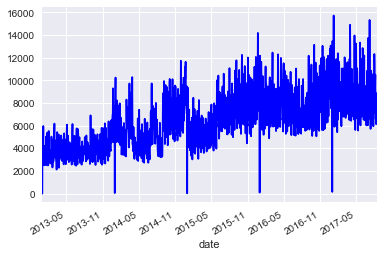

In [72]:
trainGroup = train_sample.groupby(level="date").sum()
print(trainGroup.shape)

trainGroup.unit_sales.plot(kind="line", style="blue")

In [73]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #detemine rolling statistics
    rolmean = timeseries.rolling(window="7d").mean()
    rolstd = timeseries.rolling(window="7d").std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color="blue", label="original")
    mean = plt.plot(rolmean, color="red", label="rolling_mean")
    std = plt.plot(rolstd, color="black", label="rolling_std")
    plt.legend(loc="best")
    plt.title("rolling mean & standard deviation")
    plt.show(block=False)
    
    #perform dickey-fuller test
    print("results of dickey-fuller test: ")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["test statistic","p-value", "#lags used","number of observations used"])
    for key,value in dftest[4].items():
        dfoutput["critial value (%s) "%key] = value
    print(dfoutput)

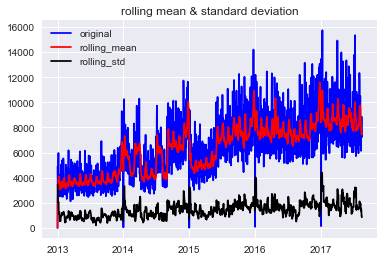

results of dickey-fuller test: 
test statistic                   -2.585697
p-value                           0.095990
#lags used                       22.000000
number of observations used    1661.000000
critial value (1%)               -3.434293
critial value (5%)               -2.863282
critial value (10%)              -2.567697
dtype: float64


In [7]:
test_stationarity(trainGroup.unit_sales)

- 1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，本数据中，adf结果为-2.58， 大于三个level的统计值。
- P-value是否非常接近0.本数据中，P-value 为 0.09>0.

**不能拒绝原假设，不平稳序列**

时间序列不稳定的原因：
- 趋势，随着时间产生不同平均值。销售量不断上升
- 季节性，特点时间段变化。节假日特征

#### 消除趋势方法
- 转换(变换为log\sqrt等)->平滑/聚合

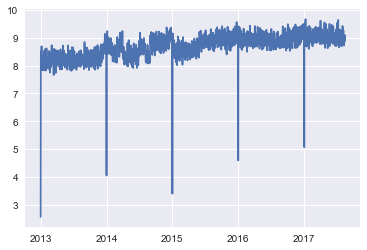

In [8]:
train_log = np.log(trainGroup.unit_sales)
plt.plot(train_log)

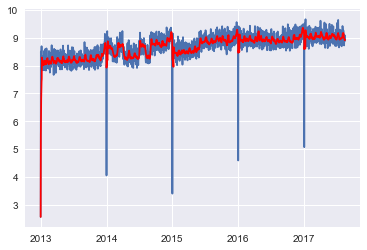

In [9]:
# 滚动平均法
moving_avg = train_log.rolling(window="7d").mean()
plt.plot(train_log)
plt.plot(moving_avg, color="red")

In [10]:
train_diff = train_log - moving_avg
train_diff.head()

date
2013-01-01    0.000000
2013-01-02    2.967416
2013-01-03    1.729774
2013-01-04    1.318067
2013-01-05    1.340259
Name: unit_sales, dtype: float64

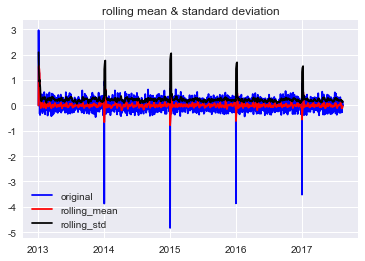

results of dickey-fuller test: 
test statistic                -1.253649e+01
p-value                        2.365451e-23
#lags used                     2.500000e+01
number of observations used    1.658000e+03
critial value (1%)            -3.434300e+00
critial value (5%)            -2.863285e+00
critial value (10%)           -2.567699e+00
dtype: float64


In [11]:
train_diff.dropna(inplace=True)
test_stationarity(train_diff)

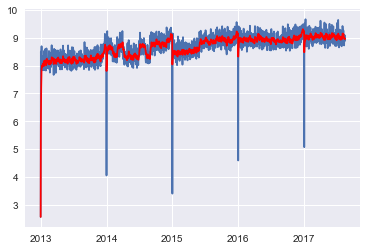

In [12]:
# 指数加权平均法
ewm_avg = train_log.ewm(span=10).mean()
plt.plot(train_log)
plt.plot(ewm_avg, color="red")

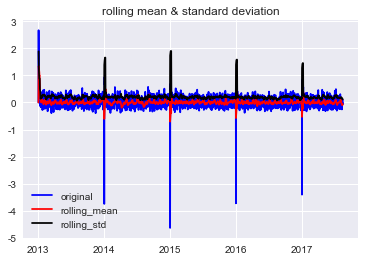

results of dickey-fuller test: 
test statistic                -1.139755e+01
p-value                        7.790991e-21
#lags used                     2.500000e+01
number of observations used    1.658000e+03
critial value (1%)            -3.434300e+00
critial value (5%)            -2.863285e+00
critial value (10%)           -2.567699e+00
dtype: float64


In [13]:
train_diff = train_log - ewm_avg
test_stationarity(train_diff)

#### 消除季节性\趋势方法
- 差分，采用一个特定时间差的差值(一阶、二阶)
- 分解，建立有关趋势和季节性模型并删除它们

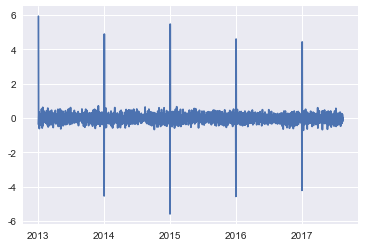

In [14]:
# 差分法 一阶差分
train_diff1 = train_log.diff()
plt.plot(train_diff1)

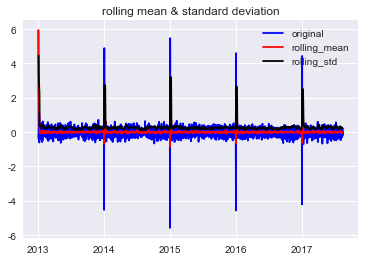

results of dickey-fuller test: 
test statistic                -1.154179e+01
p-value                        3.619654e-21
#lags used                     2.500000e+01
number of observations used    1.657000e+03
critial value (1%)            -3.434303e+00
critial value (5%)            -2.863286e+00
critial value (10%)           -2.567699e+00
dtype: float64


In [15]:
train_diff1.dropna(inplace=True)
test_stationarity(train_diff1)

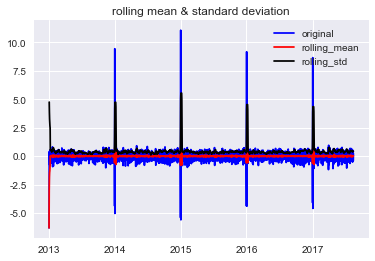

results of dickey-fuller test: 
test statistic                  -19.561149
p-value                           0.000000
#lags used                       23.000000
number of observations used    1658.000000
critial value (1%)               -3.434300
critial value (5%)               -2.863285
critial value (10%)              -2.567699
dtype: float64


In [16]:
# 二阶差分
train_diff2 = train_diff1.diff()
train_diff2.dropna(inplace=True)
test_stationarity(train_diff2)

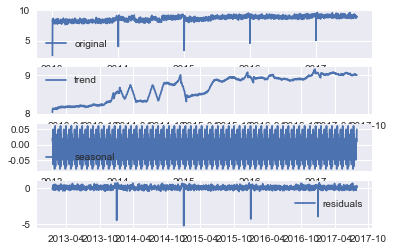

In [17]:
#　分解季节性和趋势
from statsmodels.tsa.seasonal import seasonal_decompose
train_log.dropna(inplace=True)
decomposition = seasonal_decompose(train_log,freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label="original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="residuals")
plt.legend(loc="best")

### 预测时间序列
- ARIMA，自回归整合移动平均数模型，线性回归方程
- 模型参数,ACF自相关函数/PACF偏自相关函数
 - p AR自回归项数
 - q MA移动平均项数
 - d 差分阶数
- 模型选择方法：
 - 若PACF序列满足在p步截尾，且ACF序列拖尾至0，则为AR(p)序列。 
 - 若ACF序列满足在q步截尾，且PACF序列拖尾至0，则为MA(q)序列。 
 - 若ACF序列和PACF序列满足皆不截尾，但都拖尾至0，则Yn为ARMA序列。

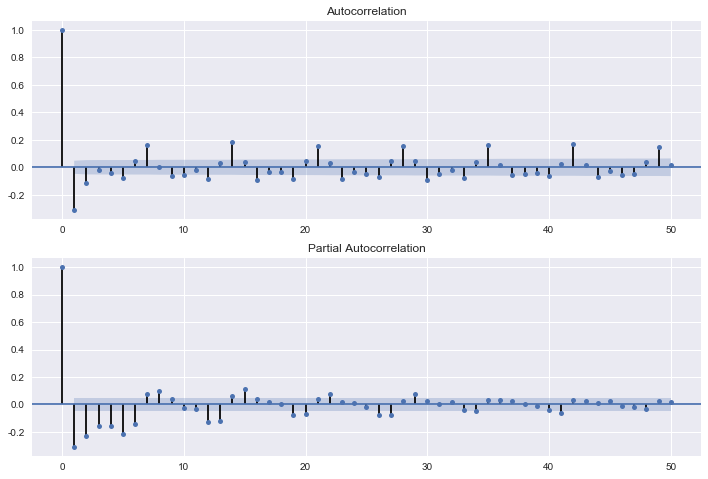

In [69]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
train_sm = train_log.diff()
train_sm.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_sm,lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_sm,lags=50,ax=ax2)

- p-部分自相关函数表第一次截断的上层置信区间是滞后值。p=8
- q- 自相关函数表第一次截断的上层置信区间是滞后值。q=7

In [19]:
from statsmodels.tsa.arima_model import ARIMA

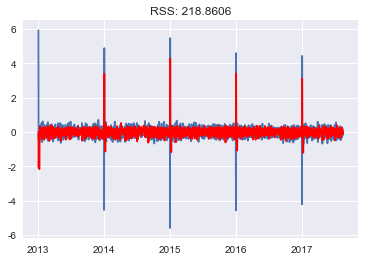

In [66]:
#AR model
model = ARIMA(train_log, order=(7,1,0))
results_AR = model.fit(disp=-1)
plt.plot(train_diff1)
plt.plot(results_AR.fittedvalues, color="red")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_diff1)**2))

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


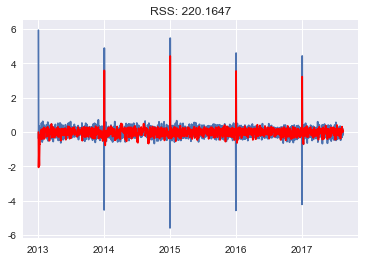

In [92]:
#ARIMA model
model = ARIMA(train_log, order=(5,1,1))
results_AR = model.fit(disp=-1)
plt.plot(train_diff1)
plt.plot(results_AR.fittedvalues, color="red")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_diff1)**2))

In [ ]:
# 数据还原

In [72]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

date
2013-01-02    0.000686
2013-01-03   -2.164058
2013-01-04   -1.606071
2013-01-05   -0.985490
2013-01-06   -1.534158
dtype: float64

In [86]:
predictions_ARIMA_log = pd.Series(train_log.iloc[:],index=train_log.index)

In [87]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff.cumsum(),fill_value=0)

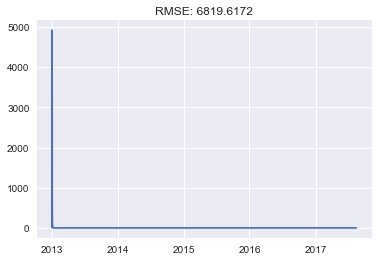

In [93]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
#plt.plot(trainGroup.unit_sales)
plt.plot(predictions_ARIMA)
plt.title("RMSE: %.4f" %np.sqrt(sum((predictions_ARIMA-trainGroup.unit_sales)**2)/len(trainGroup)))